### Imports

In [1]:
# Ajouter chemin système pour naviguer d'un dossier à l'autre facilement
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

In [2]:
########## Imports ##########

# General Imports
import numpy as np
import pandas as pd
import os, re, pickle
from packages import fonctions
from pprint import pprint
import logging

# Représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
#from Levenshtein import *

# Time
from datetime import datetime
from time import time
import time

# Import the tokenizer of NLTK
# à télécharger une fois :
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

# Sklearn
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.ensemble import IsolationForest # Outliers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# pip install fasttext

from collections import defaultdict
import multiprocessing

# LDA
#pip install pyLDAvis==2.1.2
# Import the modules
import pyLDAvis
from pyLDAvis import gensim
# Gensim
import gensim
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.models import Word2Vec
from gensim.models import TfidfModel
from gensim.models import LsiModel
from gensim.models import LdaModel
from gensim.models.phrases import Phrases, Phraser

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub

from keras import backend as K
from keras import metrics as kmetrics
from keras.optimizers import Adam
from keras.layers import *
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Transformers
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import BertTokenizer
from transformers import TFBertModel
from transformers import AdamW
from transformers import AutoTokenizer, TFAutoModel

from absl import logging

from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

# Warnings
import warnings
warnings.simplefilter(action = 'ignore')

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 100)

/Users/lucilerabeau/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/lucilerabeau/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
/Users/lucilerabeau/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
/Users/lucilerabeau/.pyenv/versions/3.9.7/envs/artefact/lib/pyt

In [3]:
# Choix d'une palette de couleurs
sns.set_palette('Set2', color_codes = True)
print(sns.color_palette('Set2').as_hex())
# palettes testées : 'Spectral', 'flare', 'twilight', 'husl', 'Set1', 'Set2', 'Set3'
sns.set_style('darkgrid')
sns.color_palette()

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [33]:
########## Import données csv ##########
# dossier data hors du dossier code pour ne pas l'importer dans github

df = pd.read_csv('../../data/df_clean.csv')
df.shape

(939, 18)

In [34]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,product_specifications,category,category_4,sous_category,sous_ensemble
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Home and Kitchen Essential,Curtains & Accessories,Curtains
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby and Personal Care,Baby Bath & Skin,Baby
2,d4684dcdc759dd9cdf41504698d737d8,2016-06-20,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Home and Kitchen Essential,Bed Linen,Bed
3,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Home and Kitchen Essential,Bed Linen,Bed
4,f355cc1ccb08bd0d283ed979b7ee7515,2015-12-04,http://www.flipkart.com/camerii-wm64-elegance-...,"Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",WATE6Y6D2MZHWGBZ,1099.0,449.0,f355cc1ccb08bd0d283ed979b7ee7515.jpg,False,"Camerii WM64 Elegance Analog Watch - For Men,...",5,5,"{""product_specification""=>[{""key""=>""Chronograp...",Wrist Watches,Electronics and Accessories,Wrist Watches,Wrist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,38782cce965307ddcdbedfcb7fa409c3,2015-12-01,http://www.flipkart.com/999store-medium-paper-...,999store Medium Paper Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE2FRBYYC92E2C,999.0,599.0,38782cce965307ddcdbedfcb7fa409c3.jpg,False,Buy 999store Medium Paper Sticker for Rs.599 o...,No rating available,No rating available,"{""product_specification""=>[{""key""=>""Sales Pack...",Baby Care,Baby and Personal Care,Baby & Kids Gifts,Baby
935,be0f39341d771aac57084970f1ed6425,2015-12-01,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Stickers Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE9F5UYBHF4MXU,1429.0,1143.0,be0f39341d771aac57084970f1ed6425.jpg,False,Buy Wallmantra Medium Vinyl Stickers Sticker f...,No rating available,No rating available,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby and Personal Care,Baby & Kids Gifts,Baby
936,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,"{""product_specification""=>[{""key""=>"

In [35]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'product_specifications', 'category', 'category_4',
       'sous_category', 'sous_ensemble'],
      dtype='object')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939 entries, 0 to 938
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  939 non-null    object 
 1   crawl_timestamp          939 non-null    object 
 2   product_url              939 non-null    object 
 3   product_name             939 non-null    object 
 4   product_category_tree    939 non-null    object 
 5   pid                      939 non-null    object 
 6   retail_price             939 non-null    float64
 7   discounted_price         939 non-null    float64
 8   image                    939 non-null    object 
 9   is_FK_Advantage_product  939 non-null    bool   
 10  description              939 non-null    object 
 11  product_rating           939 non-null    object 
 12  overall_rating           939 non-null    object 
 13  product_specifications   939 non-null    object 
 14  category                 9

In [37]:
########## Analyse du texte ##########

# librairies
# -> NLTK
# -> Spacy

# Regex cheatsheet -> https://www.debuggex.com/cheatsheet/regex/python

# recap cours
# token, retirer stopwords, stemming/lemmatization (supprimer suffixes et préfixes)

In [38]:
# Catégories
df['category_4'].value_counts()

Baby and Personal Care          282
Electronics and Accessories     254
Home and Kitchen Essential      247
Festive and Special Occasion    121
Name: category_4, dtype: int64

In [39]:
# ne garder que les deux colonnes qui nous intéressent : catégorie et description

df = df[['category_4', 'description']]
df.columns = ['category', 'description']
df.shape

(939, 2)

In [40]:
df.sample(6)

,category,description
304,Electronics and Accessories,Buy Tenda TE-W368R only for Rs. 1500 from Flip...
418,Electronics and Accessories,Clublaptop Lenovo L08O6C02 6 Cell Laptop Batte...
851,Home and Kitchen Essential,Buy eCraftIndia Floral Single Quilts & Comfort...
44,Electronics and Accessories,Key Features of RoQ Slim Multimedia 105key Fle...
736,Electronics and Accessories,Buy Fonokase SU100 SU100 USB USB Charger for R...
101,Festive and Special Occasion,Buy Exotic India Lord Ganesha (Carved in Hemat...


#### Text pre processing

In [41]:
########## TEXT PROCESSING ##########

# utiliser la description des produits car texte le plus long
# explication à développer un peu

In [42]:
def nlp_preprocessing(df, colonne, langue):

    """
    Fonction pour faire le preprocessing de la colonne d'un df
    - tokenizer
    - enlever ponctuation
    - mettre en minuscule
    - enlever stop words
    - stem
    - lemmatize

    df -> nom du dataframe sur lequel on travaille
    colonne -> nom de la colonne qu'on veut transformer (str)
    langue -> nom anglais de la langue correspondante ('french', 'spanish', 'english'...) (str)

    return -> df avec une colonne 'tokens' en plus correspondant au texte preprocessé

    """
    # tokenizer
    df['tokens'] = df[colonne].apply(word_tokenize)

    # enlever ponctuation
    df['tokens'] = df['tokens'].apply(lambda x: [item for item in x if item.isalpha()])

    # mettre en minuscule
    df['tokens'] = df['tokens'].apply(lambda x : [item.lower() for item in x])

    # enlever stop words
    stop = stopwords.words(langue)
    df['tokens'] = df['tokens'].apply(lambda x: [item for item in x if item not in stop])

    # Stem
    stemmer = PorterStemmer()
    df['stemmed'] = df['tokens'].apply(lambda x: [stemmer.stem(item) for item in x])

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    df['lemmatized'] = df['stemmed'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])

    # Remove list format
    df['clean_text'] = df['lemmatized'].apply(lambda x: ' '.join(x))

    return df

In [43]:
nlp_preprocessing(df, 'description', 'english')

,category,description,tokens,stemmed,lemmatized,clean_text
0,Home and Kitchen Essential,Key Features of Elegance Polyester Multicolor ...,"[key, features, elegance, polyester, multicolo...","[key, featur, eleg, polyest, multicolor, abstr...","[key, featur, eleg, polyest, multicolor, abstr...",key featur eleg polyest multicolor abstract ey...
1,Baby and Personal Care,Specifications of Sathiyas Cotton Bath Towel (...,"[specifications, sathiyas, cotton, bath, towel...","[specif, sathiya, cotton, bath, towel, bath, t...","[specif, sathiya, cotton, bath, towel, bath, t...",specif sathiya cotton bath towel bath towel re...
2,Home and Kitchen Essential,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[key, features, santosh, royal, fashion, cotto...","[key, featur, santosh, royal, fashion, cotton,...","[key, featur, santosh, royal, fashion, cotton,...",key featur santosh royal fashion cotton print ...
3,Home and Kitchen Essential,Key Features of Jaipur Print Cotton Floral Kin...,"[key, features, jaipur, print, cotton, floral,...","[key, featur, jaipur, print, cotton, floral, k...","[key, featur, jaipur, print, cotton, floral, k...",key featur jaipur print cotton floral king siz...
4,Electronics and Accessories,"Camerii WM64 Elegance Analog Watch - For Men,...","[camerii, elegance, analog, watch, men, boys, ...","[camerii, eleg, analog, watch, men, boy, buy, ...","[camerii, eleg, analog, watch, men, boy, buy, ...",camerii eleg analog watch men boy buy camerii ...
...,...,...,...,...,...,...
934,Baby and Personal Care,Buy 999store Medium Paper Sticker for Rs.599 o...,"[buy, medium, paper, sticker, online, medium, ...","[buy, medium, paper, sticker, onlin, medium, p...","[buy, medium, paper, sticker, onlin, medium, p...",buy medium paper sticker onlin medium paper st...
935,Baby and Personal Care,Buy Wallmantra Medium Vinyl Stickers Sticker f...,"[buy, wallmantra, medium, vinyl, stickers, sti...","[buy, wallmantra, medium, vinyl, sticker, stic...","[buy, wallmantra, medium, vinyl, sticker, stic...",buy wallmantra medium vinyl sticker sticker on...
936,Baby and Personal Care,Oren Empower Extra Large Self Adhesive Sticker...,"[oren, empower, extra, large, self, adhesive, ...","[oren, empow, extra, larg, self, adhes, sticke...","[oren, empow, extra, larg, self, adhes, sticke...",oren empow extra larg self adhes sticker pack ...
937,Baby and Personal Care,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"[buy, wallmantra, medium, vinyl, sticker, stic...","[buy, wallmantra, medium, vinyl, sticker, stic...","[buy, wallmantra, medium, vinyl, sticker, stic...",buy wallmantra medium vinyl sticker sticker on...


In [44]:
# regarder fonctions de cleaning proposées en exemple
# -> fonctions séparées (une fonction par action)

# --> faire pareil ? séparer étapes en fonctions différentes ?

In [45]:
# Maintenant que les features sont extraites -> réduction en 2 dimensions

In [46]:
# Encoding de la target
le = LabelEncoder()
le.fit(df['category'])

df['target_encoded'] = le.transform(df['category'])
df.head()

,category,description,tokens,stemmed,lemmatized,clean_text,target_encoded
0,Home and Kitchen Essential,Key Features of Elegance Polyester Multicolor ...,"[key, features, elegance, polyester, multicolo...","[key, featur, eleg, polyest, multicolor, abstr...","[key, featur, eleg, polyest, multicolor, abstr...",key featur eleg polyest multicolor abstract ey...,3
1,Baby and Personal Care,Specifications of Sathiyas Cotton Bath Towel (...,"[specifications, sathiyas, cotton, bath, towel...","[specif, sathiya, cotton, bath, towel, bath, t...","[specif, sathiya, cotton, bath, towel, bath, t...",specif sathiya cotton bath towel bath towel re...,0
2,Home and Kitchen Essential,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[key, features, santosh, royal, fashion, cotto...","[key, featur, santosh, royal, fashion, cotton,...","[key, featur, santosh, royal, fashion, cotton,...",key featur santosh royal fashion cotton print ...,3
3,Home and Kitchen Essential,Key Features of Jaipur Print Cotton Floral Kin...,"[key, features, jaipur, print, cotton, floral,...","[key, featur, jaipur, print, cotton, floral, k...","[key, featur, jaipur, print, cotton, floral, k...",key featur jaipur print cotton floral king siz...,3
4,Electronics and Accessories,"Camerii WM64 Elegance Analog Watch - For Men,...","[camerii, elegance, analog, watch, men, boys, ...","[camerii, eleg, analog, watch, men, boy, buy, ...","[camerii, eleg, analog, watch, men, boy, buy, ...",camerii eleg analog watch men boy buy camerii ...,1


### Réduction de dimensions

In [47]:
df_pca = df[['target_encoded', 'clean_text']]

In [48]:
l_cat = list(set(df['category']))
print("catégories : ", l_cat)

catégories :  [nan, 'Home and Kitchen Essential', 'Electronics and Accessories', 'Baby and Personal Care', 'Festive and Special Occasion']


In [49]:
y_cat_num = [(1-l_cat.index(df.iloc[i]['category'])) for i in range(len(df))]
y_cat_num

[0,
 -2,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 0,
 -3,
 0,
 -3,
 0,
 -2,
 0,
 -2,
 -2,
 0,
 0,
 0,
 -1,
 0,
 -2,
 0,
 -1,
 1,
 -1,
 -1,
 -1,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 0,
 0,
 -2,
 0,
 0,
 0,
 0,
 0,
 0,
 -2,
 -2,
 -2,
 -2,
 -2,
 0,
 -2,
 -3,
 -3,
 -2,
 -2,
 -3,
 -3,
 1,
 0,
 -3,
 -3,
 -3,
 -3,
 -2,
 -2,
 -2,
 -3,
 0,
 0,
 0,
 -2,
 0,
 0,
 0,
 -2,
 -3,
 -2,
 0,
 -2,
 -3,
 -1,
 0,
 -2,
 -1,
 -3,
 -2,
 -2,
 -2,
 -3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -3,
 -3,
 0,
 -3,
 0,
 -3,
 -2,
 -3,
 0,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 0,
 0,
 0,
 -2,
 -3,
 0,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 1,
 0,
 -3,
 1,
 -3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -3,
 1,
 1,
 1,
 -3,
 1,
 

In [50]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features):
    time1 = time.time()
    num_labels = len(l_cat)
    tsne = manifold.TSNE(n_components = 2, perplexity = 30, n_iter = 2000, init = 'random', learning_rate = 200, random_state = 42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters = num_labels, n_init = 100, random_state = 42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1,0)
    print('ARI : ', ARI, 'time : ', time2)

    return ARI, X_tsne, cls.labels_

# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI):
    fig = plt.figure(figsize = (15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c = y_cat_num, cmap = 'Set1')
    ax.legend(handles = scatter.legend_elements()[0], labels = l_cat, loc = 'best', title = 'Categorie')
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c = labels, cmap = 'Set1')
    ax.legend(handles = scatter.legend_elements()[0], labels = set(labels), loc = 'best', title = 'Clusters')
    plt.title('Représentation des produits par clusters')

    plt.show()
    print('ARI : ', ARI)

#### Bag of Words (BOW)

In [51]:
# création du bag of words (CountVectorizer et Tf-idf)

cvect = CountVectorizer(stop_words = 'english', max_df = 0.95, min_df = 1)
ctf = TfidfVectorizer(stop_words = 'english', max_df = 0.95, min_df = 1)

feat = 'clean_text'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])

cv_transform = cvect.transform(df[feat])
ctf_transform = ctf.transform(df[feat])

In [52]:
print('CountVectorizer : ')
print('-----------------')
ARI, X_tsne, labels = ARI_fct(cv_transform)

print('Tf-idf : ')
print('--------')
ARI, X_tsne, labels = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------
ARI :  0.2579 time :  4.0
Tf-idf : 
--------
ARI :  0.3101 time :  4.0


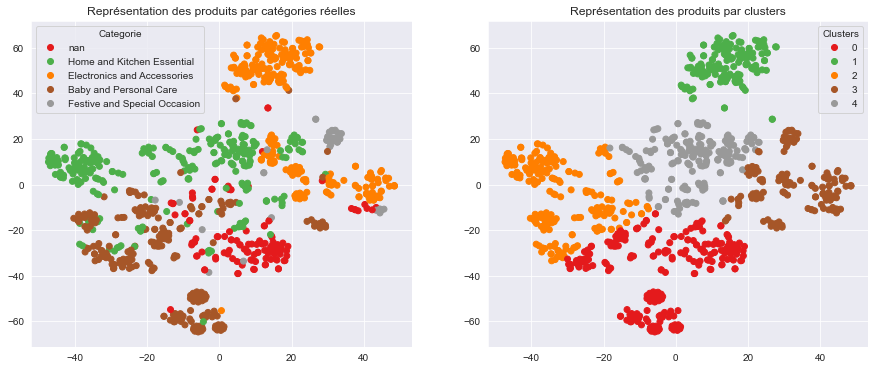

ARI :  0.3101


In [53]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [54]:
########### BOW ##########
# = Bag of words
# -> vecteur qui garde l'information de combien de fois un mot est rencontré dans un texte donné

# Compute the BOW
BOWvectorizer = CountVectorizer(stop_words = 'english')
BOW = BOWvectorizer.fit_transform(df['clean_text']).toarray()

In [55]:
BOWvectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aapno', ..., 'zone', 'zora', 'zyxel'], dtype=object)

In [56]:
#BOWvectorizer.get_feature_names() # -> ne fonctionne pas -> AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'
# dépend de la version de sklearn

In [57]:
BOW = pd.DataFrame(data = BOW, columns = BOWvectorizer.get_feature_names_out())
BOW

,aa,aaa,aapno,aarika,abil,abl,abod,abras,abroad,absolut,absorb,abstract,abstrct,ac,accent,access,accessori,accid,accident,accommod,accomplish,accord,acer,ach,acid,acn,acryl,act,activ,actual,ad,adaa,adapt,adaptor,add,addict,addit,adhes,adida,adino,adjust,admir,ador,adorn,adsl,advanc,advic,advis,aero,affect,...,wo,wok,woman,wonder,wood,wooden,woodi,woodino,wool,word,work,workmanship,workstat,world,worn,worri,worshipp,woven,wow,wrap,wrapper,wring,wrinkl,wrist,write,wrought,xemex,xl,xp,yardley,yarn,ye,year,yellow,yg,yiboo,yk,york,young,youth,yuva,zaicu,zero,zikrak,zip,zipexterior,zipper,zone,zora,zyxel
0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
935,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
937,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
BOW.shape

(939, 3336)

In [59]:
# Nombre de mots par ligne (donc pas description)
BOW.sum(axis = 1)

0      135
1       60
2      110
3      143
4       26
      ... 
934     19
935     23
936    203
937     23
938     21
Length: 939, dtype: int64

#### TF-IDF

In [61]:
########### TF-IDF ###########
# Term Frequency (TF) = nb d'occurences d'un mot dans un texte normalisé par le nb de mots dans le texte - très proche du BOW, mais ici normalisation
# Inverse Document Frequency (IDF) = inverse de la fréquence d'un terme -> va donner un poids plus important à un mot rare qu'à un mot fréquent

# TF-IDF = TF x IDF

vectorizer = TfidfVectorizer(stop_words = 'english')
tf_idf = vectorizer.fit_transform(df['clean_text']).toarray()
tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
#df_tfidf = pd.DataFrame(data = tf_idf, columns = vectorizer.get_feature_names())
df_tfidf = pd.DataFrame(data = tf_idf, columns = vectorizer.get_feature_names_out()) # attention, dépend de la version de sklearn utilisée
df_tfidf

,aa,aaa,aapno,aarika,abil,abl,abod,abras,abroad,absolut,absorb,abstract,abstrct,ac,accent,access,accessori,accid,accident,accommod,accomplish,accord,acer,ach,acid,acn,acryl,act,activ,actual,ad,adaa,adapt,adaptor,add,addict,addit,adhes,adida,adino,adjust,admir,ador,adorn,adsl,advanc,advic,advis,aero,affect,...,wo,wok,woman,wonder,wood,wooden,woodi,woodino,wool,word,work,workmanship,workstat,world,worn,worri,worshipp,woven,wow,wrap,wrapper,wring,wrinkl,wrist,write,wrought,xemex,xl,xp,yardley,yarn,ye,year,yellow,yg,yiboo,yk,york,young,youth,yuva,zaicu,zero,zikrak,zip,zipexterior,zipper,zone,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.067724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069644,0.0,0.176271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044334,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036475,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,

In [63]:
df_tfidf.shape

(939, 3336)

In [64]:
########## Similarité ##########
# similarité entre deux textes

# cosine similarity = produit scalaire entre deux vecteurs
pairwise.cosine_similarity(tf_idf)

array([[1.        , 0.04830495, 0.07207262, ..., 0.01075883, 0.00105157,
        0.00123089],
       [0.04830495, 1.        , 0.13451532, ..., 0.00449076, 0.        ,
        0.        ],
       [0.07207262, 0.13451532, 1.        , ..., 0.00902234, 0.        ,
        0.        ],
       ...,
       [0.01075883, 0.00449076, 0.00902234, ..., 1.        , 0.15702494,
        0.10934487],
       [0.00105157, 0.        , 0.        , ..., 0.15702494, 1.        ,
        0.49848893],
       [0.00123089, 0.        , 0.        , ..., 0.10934487, 0.49848893,
        1.        ]])

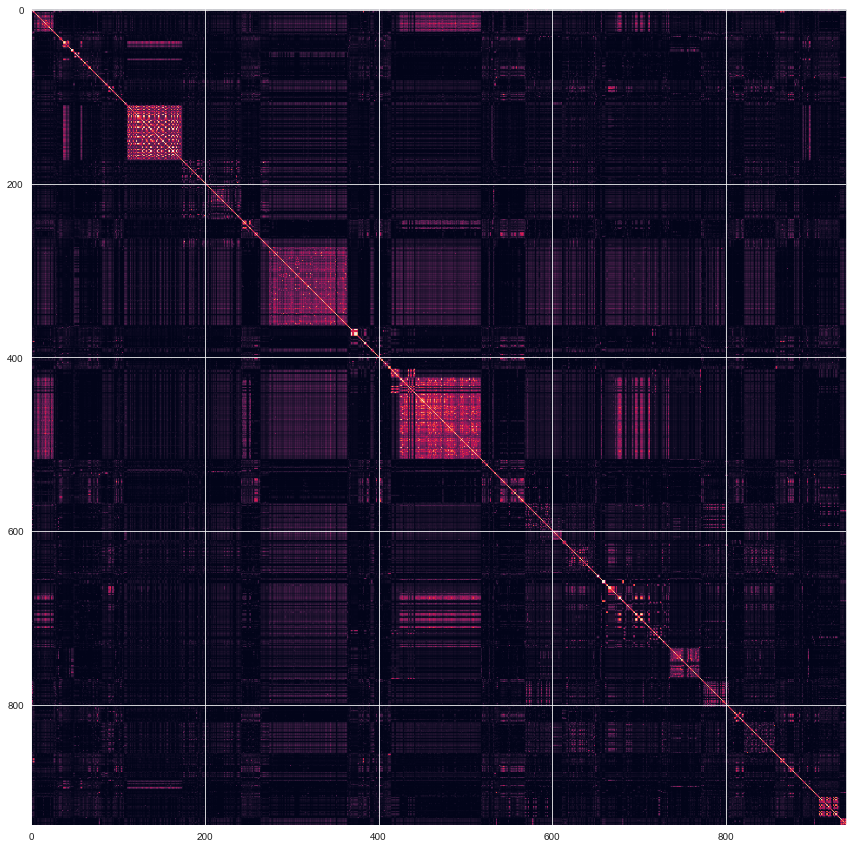

In [65]:
plt.figure(figsize = (15, 15))
plt.imshow(pairwise.cosine_similarity(tf_idf))
plt.show()

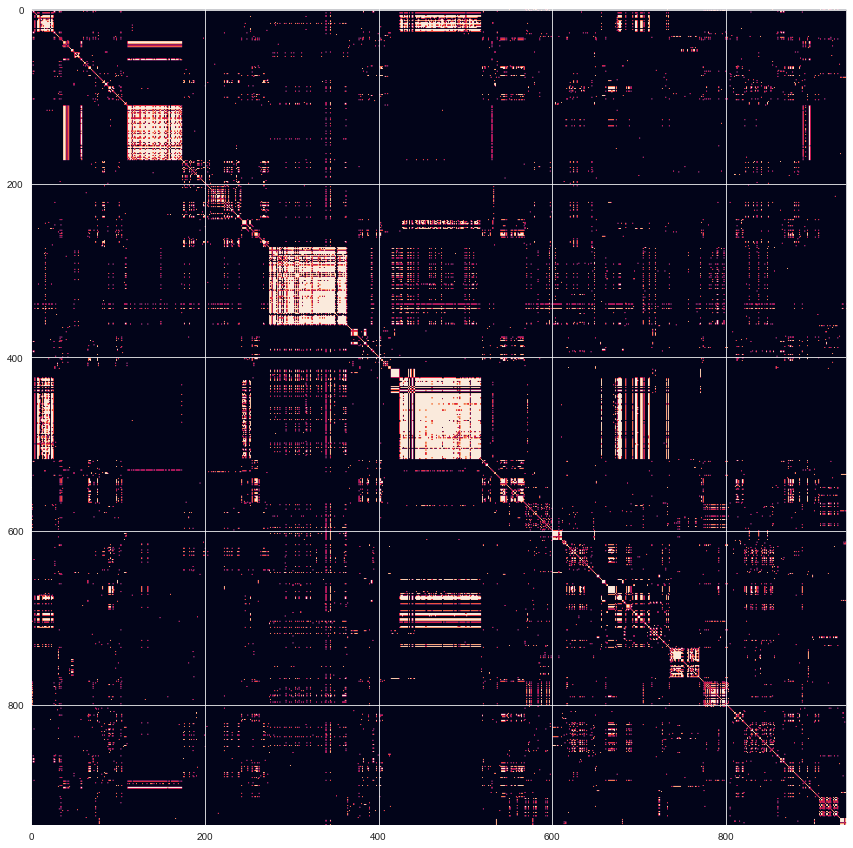

In [66]:
# définir un seuil de similarité ?

plt.figure(figsize = (15, 15))
plt.imshow(pairwise.cosine_similarity(tf_idf) > 0.2)
plt.show()


### Word embedding

In [67]:
########## Word embedding #########

# représentation matricielle, chaque mot à un nb donné de features
# idée de relation entre les mots
# but = pouvoir prédire le mot suivant dans une phrase

# GloVe, Word2Vec...

# A Word Embedding is a matrix representation, meaning each word has a given number of features. You can see the words as vectors and the features as their coordinates.
# There are many different Word Embeddings

#### GloVe

In [68]:
########## GloVe ##########
# = Global Vector
# unsupervised learning algorithm for obtaining vector representations for words

# made by Stanford NLP group -> https://nlp.stanford.edu/projects/glove/
# light word embedding, but still powerful
# several models exit, to encode words into vectors of 50, 100, 200 or even 300 dimensions


In [69]:
texts = df['clean_text']
target = df['target_encoded']

In [70]:
# Calculate the length of our vocabulary

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

3434

In [73]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('../../data/models/glove.6B/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype = 'float32')
        embeddings_dictionary [word] = vector_dimensions

# embeddings_dictionary

In [74]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.12804   ,  0.34130999,  0.33105999, ..., -0.37728   ,
         1.28989995,  0.13223   ],
       [ 0.16057   ,  0.1303    ,  0.07715   , ...,  0.021896  ,
         0.67049003,  0.03047   ],
       ...,
       [-0.18802001,  0.96000999,  0.66961002, ...,  0.081625  ,
         0.01086   ,  0.55449998],
       [-0.25308001, -0.82011002, -0.39436999, ..., -0.042999  ,
        -0.38387999,  0.69467002],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [75]:
print(embedding_matrix.shape)
pca = decomposition.PCA(n_components = 0.99)
feat_pca = pca.fit_transform(embedding_matrix)
print(feat_pca.shape)

(3434, 100)
(3434, 94)


temps de T-SNE :            15.80 secondes


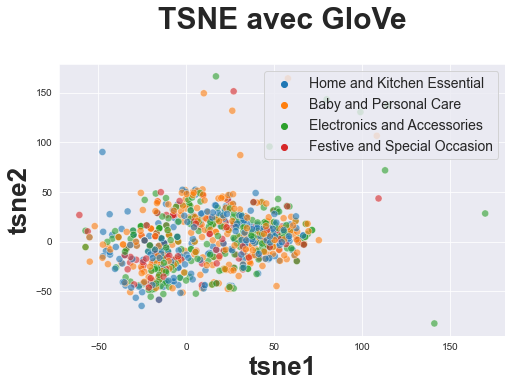

In [76]:
temps1 = time.time()

tsne = manifold.TSNE(n_components = 2, perplexity = 30, n_iter = 2000, init = 'random', random_state = 6)
X_tsne = tsne.fit_transform(feat_pca)

duration1 = time.time() - temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

df_tsne = pd.DataFrame(X_tsne, columns = ['tsne1', 'tsne2'])
df_tsne["class"] = df["category"]

plt.figure(figsize = (8,5))
sns.scatterplot(
    x = "tsne1", y = "tsne2",
    hue = "class",
    palette = sns.color_palette('tab10', n_colors = 4), s = 50, alpha = 0.6,
    data = df_tsne,
    legend = "brief")

plt.title('TSNE avec GloVe', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop = {'size': 14}) 

plt.show()

In [ ]:
# nuuuuul

#### Word2Vec

In [77]:
########## Word2Vec ##########
# -> le word embedding le plus utilisé à l'heure actuelle - puissant et versatile
# pretrained model by Google
# https://code.google.com/archive/p/word2vec/
# This model is particularly complex, thus the pretrained model is saved in a very large file (about 4 GB)

# Load Google's pre-trained Word2Vec model, give the right path to the downloaded file
model = gensim.models.KeyedVectors.load_word2vec_format('../../data/models/GoogleNews-vectors-negative300.bin', binary = True)
model

In [78]:
df['clean_text'][0]

'key featur eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain cm height pack price r curtain enhanc look curtain made high qualiti polyest featur eyelet style stitch metal make room environ romant curtain wrinkl anti shrinkag eleg home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount specif eleg polyest multicolor abstract eyelet door curtain cm height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model id color multicolor dimens length cm box number content sale packag pack sale packag curtain bodi design materi polyest'

In [79]:
# tutoriel sur kaggle -> https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial
sent = [row.split() for row in df['clean_text']]
phrases = Phrases(sent, min_count = 30, progress_per = 10000)

In [80]:
bigram = Phraser(phrases)
bigram

In [81]:
sentences = bigram[sent]
sentences

In [82]:
sentences[0]

['key_featur',
 'eleg',
 'polyest',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'eleg',
 'polyest',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'cm',
 'height',
 'pack',
 'price_r',
 'curtain',
 'enhanc',
 'look',
 'curtain',
 'made',
 'high_qualiti',
 'polyest',
 'featur',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'make',
 'room',
 'environ',
 'romant',
 'curtain',
 'wrinkl',
 'anti',
 'shrinkag',
 'eleg',
 'home',
 'bright',
 'modernist',
 'appeal',
 'design',
 'surreal',
 'attent',
 'sure',
 'steal',
 'heart',
 'contemporari',
 'eyelet',
 'valanc',
 'curtain',
 'slide',
 'smoothli',
 'draw',
 'apart',
 'first',
 'thing',
 'morn',
 'welcom',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 'good',
 'morn',
 'whole',
 'world',
 'draw',
 'close',
 'even',
 'creat',
 'special',
 'moment',
 'joyou',
 'beauti',
 'given',
 'sooth',
 'print',
 'bring',
 'home',
 'eleg',
 'curtain',
 'softli',
 'filter',
 'light',
 'room',
 'get',
 'righ

In [83]:
# Most frequent words
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

3493

In [84]:
word_freq

defaultdict(int,
            {'key_featur': 186,
             'eleg': 56,
             'polyest': 63,
             'multicolor': 150,
             'abstract': 45,
             'eyelet': 43,
             'door': 36,
             'curtain': 50,
             'floral': 56,
             'cm': 330,
             'height': 97,
             'pack': 267,
             'price_r': 311,
             'enhanc': 17,
             'look': 99,
             'made': 170,
             'high_qualiti': 62,
             'featur': 124,
             'style': 50,
             'stitch': 7,
             'metal': 31,
             'make': 101,
             'room': 53,
             'environ': 4,
             'romant': 1,
             'wrinkl': 3,
             'anti': 6,
             'shrinkag': 1,
             'home': 151,
             'bright': 17,
             'modernist': 1,
             'appeal': 13,
             'design': 324,
             'surreal': 1,
             'attent': 4,
             'sure': 37,
          

In [85]:
sorted(word_freq, key = word_freq.get, reverse = True)[:10]

['buy',
 'free_ship',
 'cash_deliveri',
 'specif',
 'product',
 'cm',
 'design',
 'color',
 'price_r',
 'day_replac']

In [86]:
cores = multiprocessing.cpu_count()

In [87]:
w2v_model = Word2Vec(
    min_count = 20,
    window = 2,
    sample = 6e-5,
    alpha = 0.03,
    min_alpha = 0.0007,
    negative = 20,
    workers = cores-1
    )

# to do -> explorer les paramètres

In [92]:
%%time
w2v_model.build_vocab(sentences, progress_per = 10000)

CPU times: user 39.8 ms, sys: 7.17 ms, total: 46.9 ms
Wall time: 73.2 ms


In [93]:
%%time
w2v_model.train(sentences, total_examples = w2v_model.corpus_count, epochs = 30, report_delay = 1)

CPU times: user 1.17 s, sys: 135 ms, total: 1.3 s
Wall time: 1.37 s


(166128, 1240380)

In [94]:
w2v_model.init_sims(replace = True)

In [95]:
w2v_model.wv.most_similar(positive = ['color'])

[('addit', 0.9963329434394836),
 ('featur', 0.995293915271759),
 ('machin', 0.9949785470962524),
 ('pack', 0.994612991809845),
 ('box_number', 0.9944454431533813),
 ('cotton', 0.9941310882568359),
 ('type', 0.9936600923538208),
 ('yellow', 0.9932292103767395),
 ('content_sale', 0.993177592754364),
 ('bleach', 0.992690920829773)]

In [96]:
w2v_model.wv.most_similar(positive = ['buy'])

[('buckl', 0.9912766814231873),
 ('watch', 0.9911631941795349),
 ('watch_men', 0.989822268486023),
 ('clasp', 0.9890792965888977),
 ('maximum', 0.9890297055244446),
 ('sonata', 0.989005982875824),
 ('digit', 0.9878095388412476),
 ('case', 0.9872936010360718),
 ('round', 0.986296534538269),
 ('gold', 0.9844170808792114)]

In [97]:
w2v_model.wv.most_similar(positive = ['watch'])

[('sonata', 0.9971385598182678),
 ('buckl', 0.9957622289657593),
 ('maximum', 0.9957295060157776),
 ('clasp', 0.9950940012931824),
 ('round', 0.9927535057067871),
 ('watch_men', 0.9918027520179749),
 ('buy', 0.9911631941795349),
 ('woman', 0.9904727935791016),
 ('water_resist', 0.9902142286300659),
 ('strap', 0.9889576435089111)]

In [98]:
w2v_model.wv.similarity('buy', 'watch')

0.9911632

In [99]:
w2v_model.wv.doesnt_match(['buy', 'color', 'carpet'])

'buy'

In [100]:
w2v_model.wv.doesnt_match(['watch', 'bracelet', 'carpet'])

'watch'

In [101]:
#tsnescatterplot(w2v_model, 'watch', ['carpet', 'buy', 'feature', 'machine', 'gold', 'table', 'clock', 'green'])
# PROBLEME ICI
# ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 300 and the array at index 1 has size 100

# à creuser

In [102]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 24 # adapt to length of sentences
sentences = df['clean_text'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [103]:
# Création et entraînement du modèle Word2Vec

print('Build & train Word2Vec model ...')
w2v_model = gensim.models.Word2Vec(
    min_count = w2v_min_count,
    window = w2v_window,
    vector_size = w2v_size,
    seed = 42,
    workers = 1,
    #workers = multiprocessing.cpu_count()
    )
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples = w2v_model.corpus_count, epochs = w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print('Vocabulary size: %i' % len(w2v_words))
print('Word2Vec trained')

Build & train Word2Vec model ...
Vocabulary size: 3414
Word2Vec trained


In [104]:
# Préparation des sentences (tokenization)

print('Fit Tokenizer ...')
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), maxlen=maxlen, padding = 'post')

num_words = len(tokenizer.word_index) + 1
print('Number of unique words: %i' % num_words)

Fit Tokenizer ...
Number of unique words: 3415


In [105]:
# Création de la matrice d'embedding

print('Create Embedding matrix ...')
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3415, 300)


In [106]:
# Création du modèle

input = Input(shape = (len(x_sentences), maxlen), dtype = 'float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

2024-03-18 12:56:28.204783: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-18 12:56:28.206590: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1024500   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,024,500
Trainable params: 1,024,500
Non-trainable params: 0
_________________________________________________________________


In [107]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

2024-03-18 12:56:29.805906: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-18 12:56:29.894027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 2ms/step


(939, 300)

In [108]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.1987 time :  4.0


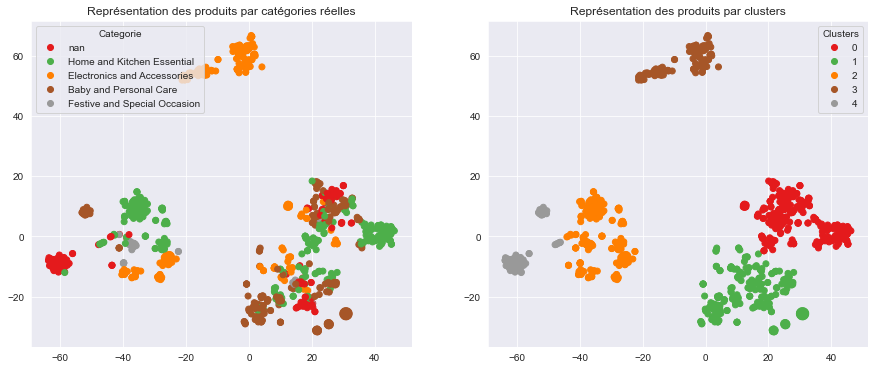

ARI :  0.1987


In [109]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

#### FastText

In [ ]:
########## FastText ##########

# developed by Facebook AI Research lab
# probably the most efficient Word Embedding
# does not only use words, but all possible n-grams (at character level) of any word to compute its embedding
# far more complex and heavy to use than the other models
# https://fasttext.cc/#

In [ ]:
# meh...

#### Latent Dirichlet Allocation (LDA)

In [ ]:
########## LDA ########### 

# Le modèle Latent Dirichlet Allocation suppose que chaque document est un mélange d’un petit nombre de topics, et que chaque occurrence d’un mot correspond à l’un des sujets du document. 
# En réalité, chaque mot se voit attribuer un topic selon la loi de Dirichlet. On obtient donc un premier topic model. Pour générer le suivant, on prend chaque mot et on met à jour le topic auquel il est associé. 
# Ce nouveau thème est celui qui aurait la plus forte probabilité de le générer dans ce document.
# Le Latent Dirichlet Allocation n’est pas un algorithme à itération unique. A la première itération, l’algorithme attribue au hasard des mots aux topics. 
# Il passe ensuite en revue chaque mot de chaque document et applique des formules de calcul de probabilité.
# Le processus est ensuite répété à travers diverses itérations jusqu’à ce que l’algorithme génère un ensemble de topics et qu’on obtiennent un modèle satisfaisant.

In [ ]:
# https://larevueia.fr/latent-dirichlet-allocation-topic-modeling-en-python/
# cours vivadata:


In [111]:
# Create a corpus
corpus = df['tokens']

# Compute the dictionary: this is a dictionary mapping words and their corresponding numbers for later visualisation
id2word = Dictionary(corpus)

# Create a BOW
bow = [id2word.doc2bow(line) for line in corpus]  # convert corpus to BoW format

# Instanciate a TF-IDF
tfidf_model = TfidfModel(bow)

# Compute the TF-IDF
tf_idf_gensim = tfidf_model[bow]

In [112]:
# Compute the LDA
lda1 = LdaModel(corpus = tf_idf_gensim, num_topics = 5, id2word = id2word, passes = 10, random_state = 0)

# Print the main topics
pprint(lda1.print_topics())

[(0,
  '0.005*"mug" + 0.003*"printland" + 0.003*"combo" + 0.003*"wireless" + '
  '0.003*"one" + 0.003*"coffee" + 0.003*"set" + 0.003*"perfect" + '
  '0.002*"guarantee" + 0.002*"replacement"'),
 (1,
  '0.005*"rockmantra" + 0.004*"ceramic" + 0.004*"mug" + 0.004*"perucci" + '
  '0.003*"creation" + 0.003*"thrilling" + 0.003*"porcelain" + 0.003*"stays" + '
  '0.003*"permanent" + 0.003*"crafting"'),
 (2,
  '0.015*"watch" + 0.014*"analog" + 0.009*"men" + 0.008*"women" + '
  '0.008*"discounts" + 0.007*"india" + 0.007*"great" + 0.006*"sonata" + '
  '0.005*"guarantee" + 0.005*"dial"'),
 (3,
  '0.006*"cm" + 0.004*"set" + 0.004*"cotton" + 0.004*"showpiece" + '
  '0.004*"mugs" + 0.003*"polyester" + 0.003*"eyelet" + 0.003*"combo" + '
  '0.003*"curtain" + 0.003*"online"'),
 (4,
  '0.006*"laptop" + 0.005*"baby" + 0.004*"skin" + 0.004*"warranty" + '
  '0.004*"girl" + 0.004*"blanket" + 0.003*"double" + 0.003*"adapter" + '
  '0.003*"fabric" + 0.003*"details"')]


In [113]:
# Instantiate the TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase = False, analyzer = lambda x: x)

# Compute the TF-IDF
tf_idf = vectorizer.fit_transform(df['tokens'])
pd.DataFrame(data = tf_idf.toarray(), columns = vectorizer.get_feature_names_out(), index = corpus.index).head()


,aa,aaa,aapno,aarika,abilities,ability,able,abode,abrasions,abroad,absolute,absorbency,absorbent,absorber,absorbing,absorbs,abstract,abstracts,abstrcts,ac,accent,access,accessories,accessory,accident,accidental,accommodate,accomplishes,according,acer,aches,aching,acid,acne,across,acrylic,act,active,acts,actual,adaa,adapter,adapters,adaptor,add,added,addiction,adding,addition,additional,...,work,working,workmanship,works,workstation,world,worn,worries,worry,worshippers,would,woven,wow,wrap,wrapped,wrapper,wring,wrinkle,wrist,write,wrought,x,xemex,xl,xp,yardley,yarn,year,years,yellow,yes,yet,ygs,yiboo,yk,york,young,youth,youthful,yuva,zaicus,zero,zikrak,zip,zipexterior,zipper,zippered,zone,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.185946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.062478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172709,0.068237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.043024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.035178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
# Dictionary mapping from word IDs to words, initialized in a lazy manner to save memory (not created until needed)
dictionary = Dictionary(df['tokens'])
print(dictionary)

Dictionary(4305 unique tokens: ['abstract', 'amount', 'anti', 'apart', 'appeal']...)


In [115]:
# Convert the TF-IDF to the needed input for Gensim
tf_idf_sklearn = Sparse2Corpus(tf_idf, documents_columns = False)

In [116]:
# Compute the LDA
lda2 = LdaModel(corpus = tf_idf_sklearn, id2word = id2word, num_topics = 5, passes = 10, random_state = 42)

# Print the main topics
pprint(lda2.print_topics())

[(0,
  '0.011*"water" + 0.008*"bong" + 0.007*"roll" + 0.007*"monster" + '
  '0.006*"works" + 0.006*"cloth" + 0.005*"combinations" + 0.005*"century" + '
  '0.004*"deployment" + 0.004*"shrug"'),
 (1,
  '0.017*"airtex" + 0.015*"santosh" + 0.012*"decals" + 0.012*"layered" + '
  '0.012*"received" + 0.012*"cooling" + 0.012*"diamond" + 0.012*"traits" + '
  '0.012*"handcrafted" + 0.011*"uv"'),
 (2,
  '0.006*"persnalized" + 0.006*"relief" + 0.005*"meet" + 0.005*"seeds" + '
  '0.004*"balances" + 0.004*"volume" + 0.004*"embroidered" + 0.004*"received" '
  '+ 0.004*"image" + 0.004*"three"'),
 (3,
  '0.008*"traits" + 0.008*"cooling" + 0.008*"diamond" + 0.008*"handcrafted" + '
  '0.008*"agromech" + 0.008*"three" + 0.008*"uv" + 0.007*"insert" + '
  '0.006*"luxury" + 0.005*"burner"'),
 (4,
  '0.008*"enabled" + 0.005*"relief" + 0.005*"short" + 0.004*"ravishing" + '
  '0.004*"empire" + 0.003*"supercritical" + 0.003*"printland" + '
  '0.003*"utility" + 0.003*"fengshui" + 0.003*"secondary"')]


In [117]:
# LDA visualization

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model = lda1, corpus = bow, dictionary = id2word)
vis

/Users/lucilerabeau/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/lucilerabeau/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/lucilerabeau/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/lucilerabeau/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for al

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.015769 -0.052888       1        1  29.085517
2      0.084547  0.011157       2        1  27.783768
3     -0.006134 -0.022680       3        1  25.245417
0     -0.035527  0.020190       4        1  10.406857
1     -0.027118  0.044220       5        1   7.478442, topic_info=          Term        Freq       Total Category  logprob  loglift
184      watch  219.000000  219.000000  Default  30.0000  30.0000
168     analog  198.000000  198.000000  Default  29.0000  29.0000
114      women  126.000000  126.000000  Default  28.0000  28.0000
106        men  134.000000  134.000000  Default  27.0000  27.0000
174  discounts  110.000000  110.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
413    ceramic   14.877871   76.676533   Topic5  -5.4768   0.9534
614       gift    9.952353   49.898265   Topic5  -5.8789   0.9810
623        mug   14.636989  108.266199   Topic5  -5.4931   0.5921
111      towel    9.590294   48.999281   Topic5  -5.9159   0.9621
20      design    9.836587   64.700355   Topic5  -5.8906   0.7095

[291 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2104      1  0.899102  adapter
2104      2  0.021929  adapter
2104      3  0.021929  adapter
2104      4  0.021929  adapter
2104      5  0.021929  adapter
...     ...       ...      ...
2027      1  0.196531     york
2027      2  0.098266     york
2027      3  0.098266     york
2027      4  0.491329     york
2027      5  0.098266     york

[1105 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

In [118]:
# Trouver comment visualiser avec fond blanc sinon on voit rien

In [119]:
#(cf cours openclassrooms)
n_topics = 20

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components = n_topics,
        max_iter = 5,
        learning_method = 'online',
        learning_offset = 50.,
        random_state = 0
        )

# Fitter sur les données
lda.fit(df['description_dl'])

ValueError: could not convert string to float: 'key featur eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain cm height pack price r curtain enhanc look curtain made high qualiti polyest featur eyelet style stitch metal make room environ romant curtain wrinkl anti shrinkag eleg home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount specif eleg polyest multicolor abstract eyelet door curtain cm height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model id color multicolor dimens length cm box number content sale packag pack sale packag curtain bodi design materi polyest'

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

In [ ]:
########## NMF ########### (cf cours openclassrooms)
# NMF = Negative Matrix Factorisation
# = modélisation de sujet automatique non supervisée

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(
    max_df = 0.95, 
    min_df = 2, 
    max_features = no_features, 
    stop_words = 'english'
    )
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = NMF(n_components = no_topics, random_state = 1, alpha = .1, l1_ratio = .5, init = 'nndsvd')
nmf.fit(tfidf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)

#### BERT

In [120]:
########## BERT ###########

# Liens ressources Openclassrooms :
# https://huggingface.co/docs/transformers/index
# https://github.com/google-research/bert
# https://lesdieuxducode.com/blog/2019/4/bert--le-transformer-model-qui-sentraine-et-qui-represente
# https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertModel
# https://www.kaggle.com/models/tensorflow/bert/frameworks/tensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4?tfhub-redirect=true

# tutoriel
# https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation

#### specify GPU
# cuda = parallel computing platform by NVIDIA, for efficient GPU acceleration
# si mal installé -> erreurs ensuite
device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


In [121]:
df

,category,description,tokens,stemmed,lemmatized,clean_text,target_encoded
0,Home and Kitchen Essential,Key Features of Elegance Polyester Multicolor ...,"[key, features, elegance, polyester, multicolo...","[key, featur, eleg, polyest, multicolor, abstr...","[key, featur, eleg, polyest, multicolor, abstr...",key featur eleg polyest multicolor abstract ey...,3
1,Baby and Personal Care,Specifications of Sathiyas Cotton Bath Towel (...,"[specifications, sathiyas, cotton, bath, towel...","[specif, sathiya, cotton, bath, towel, bath, t...","[specif, sathiya, cotton, bath, towel, bath, t...",specif sathiya cotton bath towel bath towel re...,0
2,Home and Kitchen Essential,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[key, features, santosh, royal, fashion, cotto...","[key, featur, santosh, royal, fashion, cotton,...","[key, featur, santosh, royal, fashion, cotton,...",key featur santosh royal fashion cotton print ...,3
3,Home and Kitchen Essential,Key Features of Jaipur Print Cotton Floral Kin...,"[key, features, jaipur, print, cotton, floral,...","[key, featur, jaipur, print, cotton, floral, k...","[key, featur, jaipur, print, cotton, floral, k...",key featur jaipur print cotton floral king siz...,3
4,Electronics and Accessories,"Camerii WM64 Elegance Analog Watch - For Men,...","[camerii, elegance, analog, watch, men, boys, ...","[camerii, eleg, analog, watch, men, boy, buy, ...","[camerii, eleg, analog, watch, men, boy, buy, ...",camerii eleg analog watch men boy buy camerii ...,1
...,...,...,...,...,...,...,...
934,Baby and Personal Care,Buy 999store Medium Paper Sticker for Rs.599 o...,"[buy, medium, paper, sticker, online, medium, ...","[buy, medium, paper, sticker, onlin, medium, p...","[buy, medium, paper, sticker, onlin, medium, p...",buy medium paper sticker onlin medium paper st...,0
935,Baby and Personal Care,Buy Wallmantra Medium Vinyl Stickers Sticker f...,"[buy, wallmantra, medium, vinyl, stickers, sti...","[buy, wallmantra, medium, vinyl, sticker, stic...","[buy, wallmantra, medium, vinyl, sticker, stic...",buy wallmantra medium vinyl sticker sticker on...,0
936,Baby and Personal Care,Oren Empower Extra Large Self Adhesive Sticker...,"[oren, empower, extra, large, self, adhesive, ...","[oren, empow, extra, larg, self, adhes, sticke...","[oren, empow, extra, larg, self, adhes, sticke...",oren empow extra larg self adhes sticker pack ...,0
937,Baby and Personal Care,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"[buy, wallmantra, medium, vinyl, sticker, stic...","[buy, wallmantra, medium, vinyl, sticker, stic...","[buy, wallmantra, medium, vinyl, sticker, stic...",buy wallmantra medium vinyl sticker sticker on...,0


In [122]:
df.columns

Index(['category', 'description', 'tokens', 'stemmed', 'lemmatized',
       'clean_text', 'target_encoded'],
      dtype='object')

In [123]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['clean_text'], df['target_encoded'], random_state = 2018, test_size = 0.3)

In [124]:
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state = 2018, test_size = 0.5)

In [125]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: 100%|██████████| 48.0/48.0 [00:00<00:00, 26.5kB/s]


<AxesSubplot:>

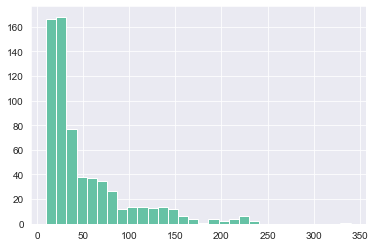

In [126]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [127]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

except:
    strategy = tf.distribute.get_strategy()

print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [128]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = maximum_length,
            pad_to_max_length = True,

            return_attention_mask = True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids), np.array(attention_masks)

Downloading: 100%|██████████| 48.0/48.0 [00:00<00:00, 22.4kB/s]


In [129]:
texts = df['clean_text']
target = df['target_encoded']

train_input_ids, train_attention_masks = bert_encode(texts, 60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [130]:


def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape = (60,), dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (60,), dtype = 'int32')

    output = bert_model([input_ids, attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32, activation = 'relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
    model.compile(Adam(lr = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [131]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [132]:
model = create_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

In [133]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split = 0.2,
    epochs = 3,
    batch_size = 10
)

Epoch 1/3


2024-03-18 13:00:53.228319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x1xi1>'
loc

75/76 [============================>.] - ETA: 0s - loss: -1.3434 - accuracy: 0.2973

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShad

76/76 [==============================] - ETA: 0s - loss: -1.3535 - accuracy: 0.2969

2024-03-18 13:02:34.357203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x1xi1>'


76/76 [==============================] - 129s 1s/step - loss: -1.3535 - accuracy: 0.2969 - val_loss: -4.5817 - val_accuracy: 0.1649
Epoch 2/3


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8x1x1xi1>'


76/76 [==============================] - 142s 2s/step - loss: -5.0313 - accuracy: 0.3156 - val_loss: -2.5548 - val_accuracy: 0.2660
Epoch 3/3
76/76 [==============================] - 140s 2s/step - loss: -9.0735 - accuracy: 0.4381 - val_loss: -11.0886 - val_accuracy: 0.2766


In [134]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize = (20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]], fontsize = 18)
        ax[idx].set_xlabel('A',fontsize = 16)
        ax[idx].set_ylabel('B',fontsize = 16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1], fontsize = 16)

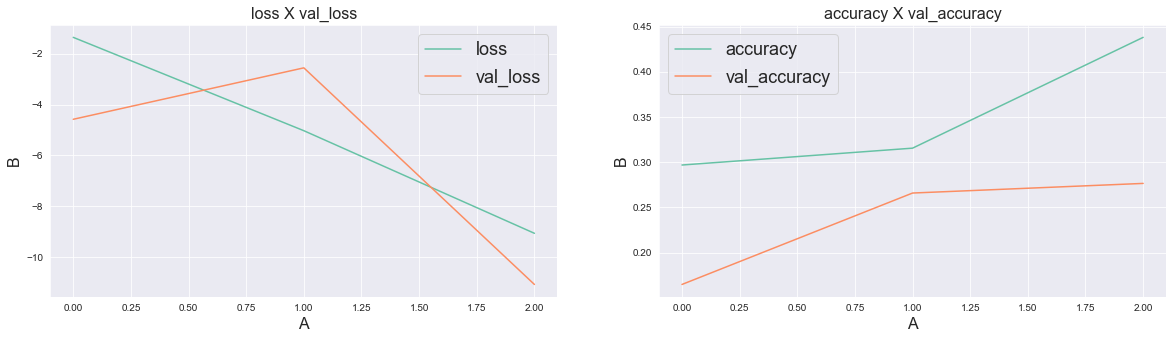

In [135]:
plot_learning_curves(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

In [136]:
# faire predict

(3415, 300)
(3415, 97)
temps de T-SNE :            18.57 secondes


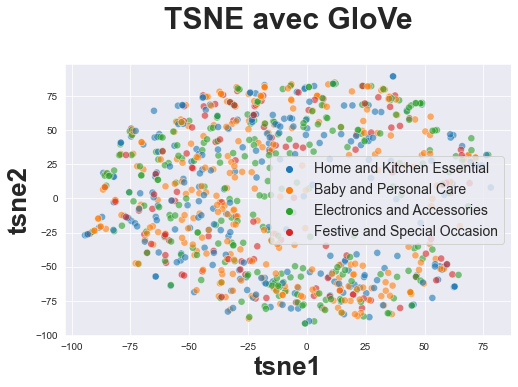

In [137]:
print(embedding_matrix.shape)
pca = decomposition.PCA(n_components = 0.99)
feat_pca = pca.fit_transform(embedding_matrix)
print(feat_pca.shape)

temps1 = time.time()

tsne = manifold.TSNE(n_components = 2, perplexity = 30, n_iter = 2000, init = 'random', random_state = 6)
X_tsne = tsne.fit_transform(feat_pca)

duration1 = time.time() - temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

df_tsne = pd.DataFrame(X_tsne, columns = ['tsne1', 'tsne2'])
df_tsne["class"] = df["category"]

plt.figure(figsize = (8,5))
sns.scatterplot(
    x = "tsne1", y = "tsne2",
    hue = "class",
    palette = sns.color_palette('tab10', n_colors = 4), s = 50, alpha = 0.6,
    data = df_tsne,
    legend = "brief")

plt.title('TSNE avec GloVe', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop = {'size': 14}) 

plt.show()

In [138]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

In [139]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [140]:
# https://stackoverflow.com/questions/65804689/with-bert-text-classification-valueerror-too-many-dimensions-str-error-occur
# The issue is you are passing a list of strings (str) in torch.tensor() , it only accepts the list of numerical values (integer, float etc.)
# -> solution : convertir les labels en int (dictionnaire)

df['category'].unique()

array(['Home and Kitchen Essential', 'Baby and Personal Care',
       'Electronics and Accessories', 'Festive and Special Occasion', nan],
      dtype=object)

In [141]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['clean_text'], df['target_encoded'], random_state = 2018, test_size = 0.3)
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state = 2018, test_size = 0.5)

<AxesSubplot:>

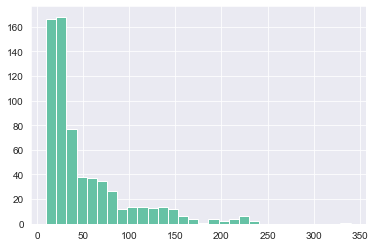

In [142]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [143]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

In [144]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [145]:


#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

In [146]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [147]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim = 1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [148]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [149]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)

In [150]:
#compute the class weights
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)
print("Class Weights:", class_weights)

Class Weights: [0.67384615 0.76395349 1.54588235 0.73820225 4.86666667]


In [152]:
df['target_encoded'].unique()

array([3, 0, 1, 2, 4])

In [153]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = df['target_encoded'].unique(), y = train_labels)
print("Class Weights:", class_weights)

Class Weights: [0.73820225 0.67384615 0.76395349 1.54588235 4.86666667]


In [ ]:
# séparation train/test -> vérifier si certains labels se sont retrouvés exclusivement dans train ou dans test

In [154]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights, dtype = torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight = weights) 

# number of training epochs
epochs = 10

In [155]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds = []
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis = 0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [156]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [157]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


RuntimeError: weight tensor should be defined either for all 2 classes or no classes but got weight tensor of shape: [5]

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [158]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding = 'max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids = True,
                                              truncation = True,
                                              return_tensors = 'tf')

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode = 'HF'):
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step * batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], bert_tokenizer, max_length)
        if mode == 'HF':    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub': # Bert Tensorflow Hub
            text_preprocessed = {'input_word_ids' : input_ids,
                                 'input_mask' : attention_mask,
                                 'input_type_ids' : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print('temps traitement : ', time2)
    
    return features_bert, last_hidden_states_tot

In [159]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['clean_text'].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [160]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, max_length, batch_size, mode = 'HF')

2024-03-18 13:14:02.762420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 54ms/step
temps traitement :  34.0


In [161]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ValueError: Found input variables with inconsistent numbers of samples: [939, 930]

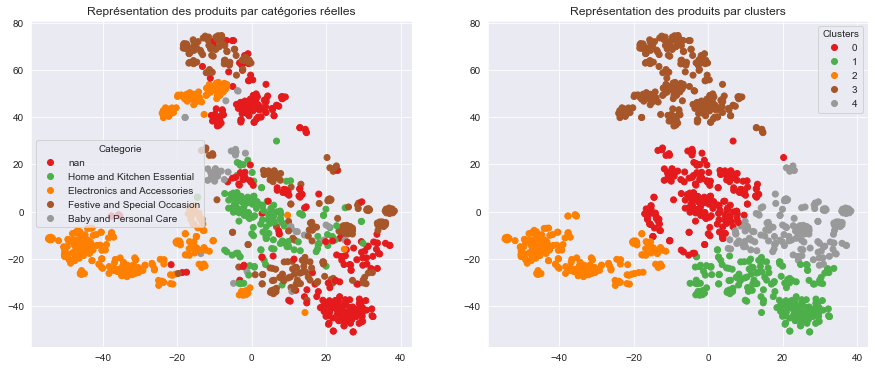

ARI :  0.2093


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

#### Universal Sentence Encoder (USE)

In [164]:
########## USE (Universal Sentence Encoder) ##########

# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder?hl=fr


#module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
module_path = '../../data/models/universal_sentence_encoder/saved_model.pb'
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

ValueError: Trying to load a model of incompatible/unknown type. '/var/folders/z2/zv19yvhx0d7b6fj17_n0489w0000gn/T/tfhub_modules/063d866c06683311b44b4992fd46003be952409c' contains neither 'saved_model.pb' nor 'saved_model.pbtxt'.

In [165]:
# Universal Sentence Encoder encodes entire sentence or text into vectors of real numbers that can be used for clustering, sentence similarity, text classification, 
# and other Natural language processing (NLP) tasks.
# The pre-trained model is trained on greater than word length text, sentences, phrases, paragraphs, etc using a deep averaging network (DAN) encoder.

# word embedding -> represent word into vectors
# sentence embedding -> entire sentence or text along with semantics information is mapped into vectors of real numbers

In [166]:
# test avec les exemples donnés

word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

NameError: name 'embed' is not defined

In [167]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

In [168]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

run_and_plot(messages)

NameError: name 'embed' is not defined

In [169]:
run_and_plot(df['clean_text'])

NameError: name 'embed' is not defined

In [170]:
# test avec mon jeu de données
# https://www.geeksforgeeks.org/word-embedding-using-universal-sentence-encoder-in-python/

sentences = df['clean_text']

embeddings = embed(sentences)

# Printing embeddings of each sentence
print(embeddings) 
  
# To print each embeddings along with its corresponding sentence below code can be used.
for i in range(len(sentences)): 
    print(sentences[i]) 
    print(embeddings[i])

NameError: name 'embed' is not defined

In [171]:
#Explanation:
#The above output represents input sentences into their corresponding vectors using the Universal Sentence encoder.

In [172]:
os.environ["TF_KERAS"]='1'

In [175]:
# modele 4 -> marche pas
#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/3")
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")

ValueError: Trying to load a model of incompatible/unknown type. '/var/folders/z2/zv19yvhx0d7b6fj17_n0489w0000gn/T/tfhub_modules/744ecc8f0e54abfc94870bb7a86ec2c67e8724da' contains neither 'saved_model.pb' nor 'saved_model.pbtxt'.

In [ ]:
# si ne fonctionne pas comme ça, télécharger le modèle et le charger en local

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10
sentences = df['clean_text'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

2024-02-16 17:08:25.847655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.2072 time :  5.0


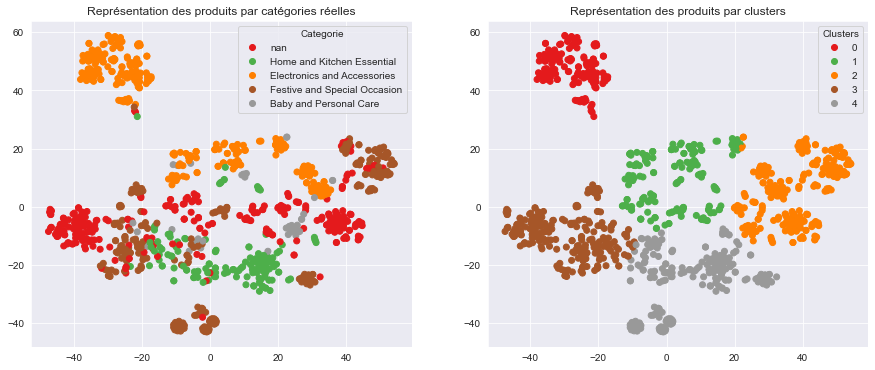

ARI :  0.2072


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Comparaison

In [ ]:
# A faire -> comparer la performance des différentes approches (avec/sans bow/tfidf, avec/sans word embedding et comparer les 3 word embedding differents)

In [ ]:
########## CONCLUSION ##########

# -> à dire en ouverture
# analyse de texte basée sur description des produits semble pertinente car blablabla
# cependant, repose sur description -> il faut donc avec une description relativement pertinente du produit déjà disponible pour pouvoir le classifier automatiquement - pas super pratique